# Introduction

This example builds upon the previous MNIST-dimensionality-reduction example [[ipynb](https://github.com/trangel/Data-Science/blob/master/MNIST-dimensionality-reduction.ipynb)].

Here we train a neural network to predict a sequence of hand written digits of the MNIST dataset.
We will prepare the data using dimensionality reduction following the previous example.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE



# MNIST Dataset
We choose the popular MNIST (Mixed National Institute of Standards and Technology) computer vision digit dataset. This contains a series for images of handwriting letters, each of them of 28x28 pixels, see a few pick below.


The datasets are large, please download them from:
https://pjreddie.com/projects/mnist-in-csv/

In [2]:
train = pd.read_csv('./datasets/mnist_train.csv').head(5000)
#reduce the size to 3000 to make things fast

columns=[]
columns.append("label")
for ii in range(784):
    columns.append("pixel"+str(ii+1))
train.columns=columns
    
print("Shape of train dataset: "+str(train.shape))
train.head()

Shape of train dataset: (5000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The MNIST set consists of 59999 rows and 785 columns. There are 28 x 28 pixel images of digits ( contributing to 784 columns) as well as one extra label column which is essentially a class label to state whether the row-wise contribution to each digit gives a 1 or a 9. See a few pics here.

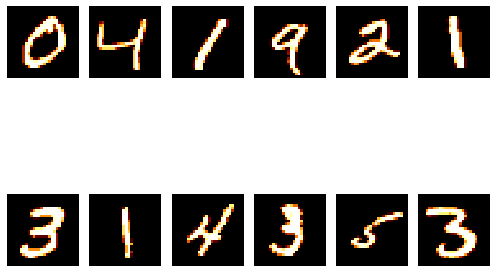

In [3]:
# Copy the features and target columns to different arrays: 
y_train= train['label']
# Drop the label feature
X_train = train.drop("label",axis=1)

# plot some of the numbers
plt.figure(figsize=(7,7))
for digit_num in range(0,12):
    plt.subplot(2,6,digit_num+1)
    grid_data = X_train.iloc[digit_num,:].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


Now we proceed to reduce the dimensionality of our dataset using PCA, as in the previous example. For this case the neural network performs better if followed by a dimensionality reduction.

In [4]:
#Note than n_components for lda is < n_class (9)


dimensionality_reduction_method="pca"
n_components=50
reduction_method = PCA(n_components=n_components)

print ( "Reducing dimensionality to %d components\n" %(n_components))
    
print(X_train.shape)

#del X_train_red
# Taking in as second argument the Target as labels
reduction_method = reduction_method.fit(X_train.values, y_train.values )
X_train_red = reduction_method.transform(X_train.values)
print(X_train_red.shape)


Reducing dimensionality to 50 components

(5000, 784)
(5000, 50)


In [5]:
test = pd.read_csv('./datasets/mnist_test.csv')
test.columns=columns
               
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# save the labels to a Pandas series target
y_test = test['label']
# Drop the label feature
X_test = test.drop("label",axis=1)

In [7]:
X_test_red = reduction_method.transform(X_test) 


## Standarize data:
sklearn provides tools to standarize data as follows. 

In [8]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train_red)  
X_train_red = scaler.transform(X_train_red)  
# apply same transformation to test data
X_test_red = scaler.transform(X_test_red) 

## Neural network
Use a neural network to predict

In [9]:
#use regularization alpha=1e-5
#25 hidden layers

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(50,), random_state=1)

clf.fit(X_train_red, y_train)   
y_pred=clf.predict(X_test_red)

Now let's check the performance of the neural network.

Remember the precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [10]:
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report



#Precision score for test dataset:
print("Precision score for test dataset: \n")
precision_score(y_test, y_pred, average='micro')


Precision score for test dataset: 



0.91589158915891589

# Results:


With a neural network consisting of 50 hidden layers, we achieve a precision score > 0.9. This compares to the score for a polynomial fit in the previous example (~0.9).

